In [28]:
# Import necessary libraries
import os
import numpy as np
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.feature import hog, local_binary_pattern
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from pandas import DataFrame



In [16]:
# Correct dataset path
dataset_path = "C:\\Users\\omars\\Downloads\\EnglishHnd\\EnglishHnd\\English\\Hnd\\Img"

# Check if dataset path exists
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"Dataset path not found: {dataset_path}")

# Initialize variables
data = []
labels = []

# Define image size
image_size = (64, 64)

# Load and preprocess dataset
print("Loading dataset...")
valid_classes = []
class_counts = {}

# Count images in each class
for class_dir in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_dir)
    if os.path.isdir(class_path):
        class_counts[class_dir] = len([file for file in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, file))])

# Sort classes by frequency and select the top N classes
sorted_classes = sorted(class_counts, key=class_counts.get, reverse=True)[:19]  # Adjust the number as needed

for class_dir in sorted_classes:
    class_path = os.path.join(dataset_path, class_dir)
    valid_classes.append(class_dir)
    for file_name in os.listdir(class_path):
        file_path = os.path.join(class_path, file_name)
        try:
            # Load and resize image
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, image_size)

            # Append data and labels
            data.append(img)
            labels.append(valid_classes.index(class_dir))  # Use the index of the valid class
        except Exception as e:
            print(f"Error loading image: {file_path}, {e}")

# Convert to numpy arrays
data = np.array(data)
labels = np.array(labels)

# Ensure valid_classes matches the actual classes present in the subset
unique_labels = np.unique(labels)
valid_classes = [valid_classes[i] for i in unique_labels]

# Load a subset of the dataset for quick experimentation
subset_size = 1000  # Adjust this size based on your dataset
data_subset = data[:subset_size]
labels_subset = labels[:subset_size]



Loading dataset...


In [17]:
# Extract HOG and LBP features
print("Extracting features...")
features = []
for img in data_subset:
    hog_features = hog(img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)
    lbp = local_binary_pattern(img, P=8, R=1.0, method="uniform")
    lbp_features, _ = np.histogram(lbp, bins=np.arange(0, 11), range=(0, 10))
    combined_features = np.hstack((hog_features, lbp_features))
    features.append(combined_features)
features = np.array(features)


Extracting features...


In [18]:
# Standardize features and apply PCA
print("Standardizing features and applying PCA...")
scaler = StandardScaler()
features = scaler.fit_transform(features)

pca = PCA(n_components=0.95)  # Keep 95% of the variance
features = pca.fit_transform(features)


Standardizing features and applying PCA...


In [19]:
# Balance dataset with SMOTE
print("Balancing dataset with SMOTE...")
smote = SMOTE(random_state=42)
features, labels = smote.fit_resample(features, labels_subset)


Balancing dataset with SMOTE...


c:\Users\omars\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\omars\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [20]:
# Split dataset into training and test sets
print("Splitting dataset into training and test sets...")
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)


Splitting dataset into training and test sets...


In [21]:
# Quick hyperparameter tuning using RandomizedSearchCV
print("Tuning hyperparameters...")
param_distributions = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
random_search = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_distributions, n_iter=10, cv=3, n_jobs=-1, verbose=2)
random_search.fit(X_train, y_train)
best_classifier = random_search.best_estimator_


Tuning hyperparameters...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [22]:
# Evaluate model
print("Evaluating model...")
y_pred = best_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Generate the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=valid_classes))


Evaluating model...
Test Accuracy: 60.29%
Classification Report:
              precision    recall  f1-score   support

   Sample001       0.57      0.73      0.64        11
   Sample002       0.73      0.61      0.67        18
   Sample003       0.29      0.33      0.31         6
   Sample004       0.50      0.50      0.50        12
   Sample005       0.40      0.57      0.47         7
   Sample006       0.82      0.53      0.64        17
   Sample007       0.46      0.60      0.52        10
   Sample008       0.54      0.88      0.67         8
   Sample009       0.71      0.62      0.67        16
   Sample010       0.20      0.25      0.22         8
   Sample011       0.82      0.82      0.82        11
   Sample012       0.33      0.25      0.29        12
   Sample013       0.73      0.67      0.70        12
   Sample014       0.50      0.89      0.64         9
   Sample015       0.57      0.44      0.50         9
   Sample016       1.00      0.69      0.82        13
   Sample017    

Plotting Confusion Matrix...


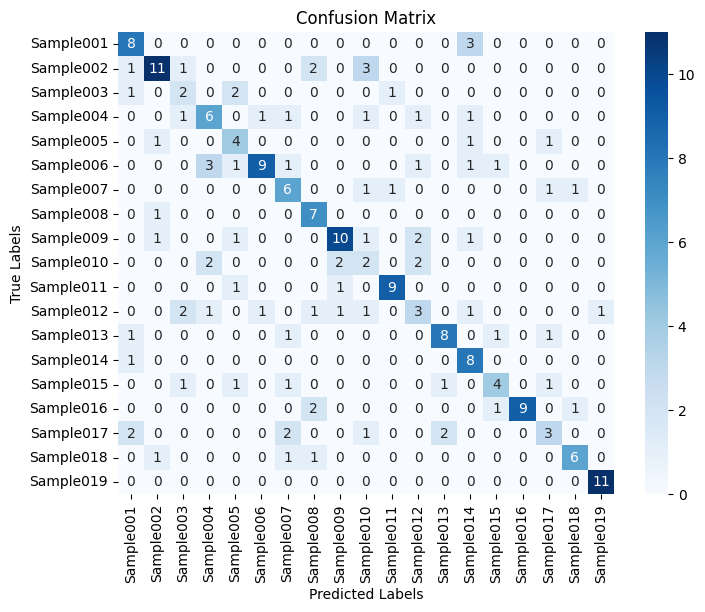

In [23]:

# Confusion Matrix
print("Plotting Confusion Matrix...")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=valid_classes, yticklabels=valid_classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


Calculating AUC...
AUC Value: 0.92


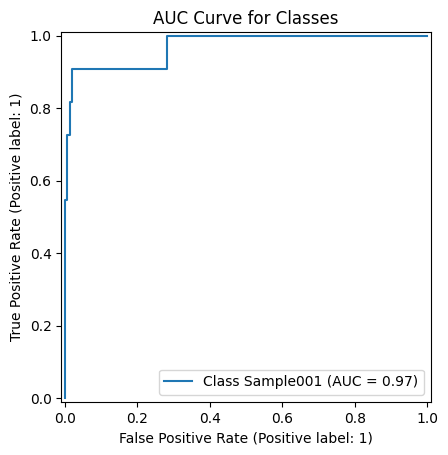

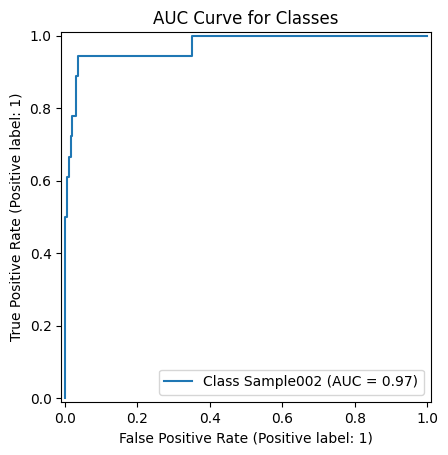

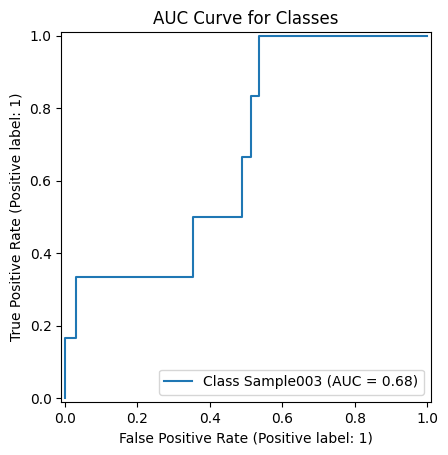

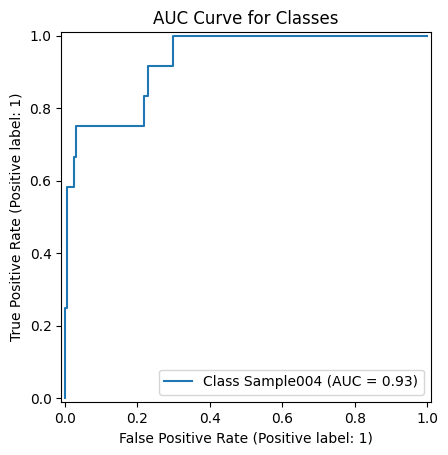

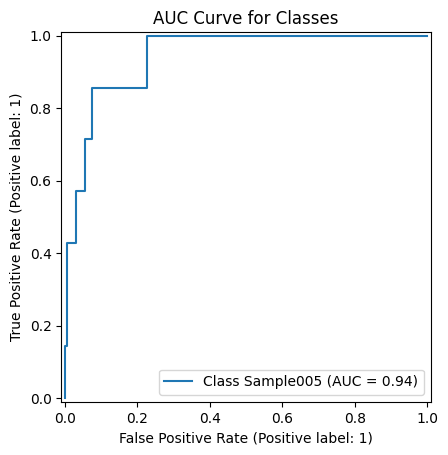

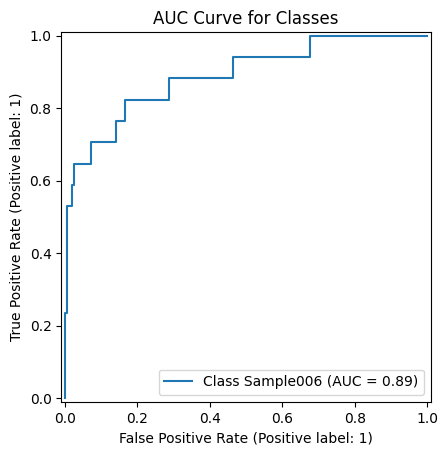

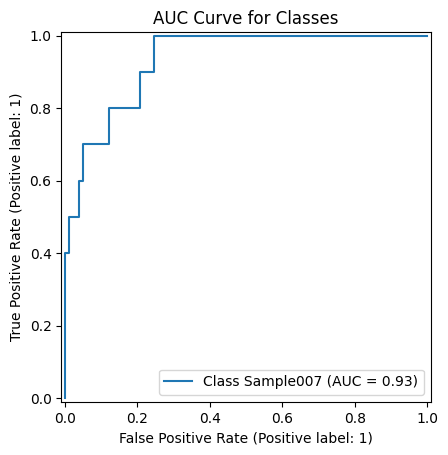

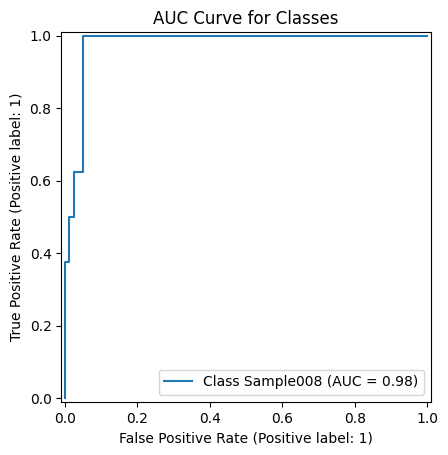

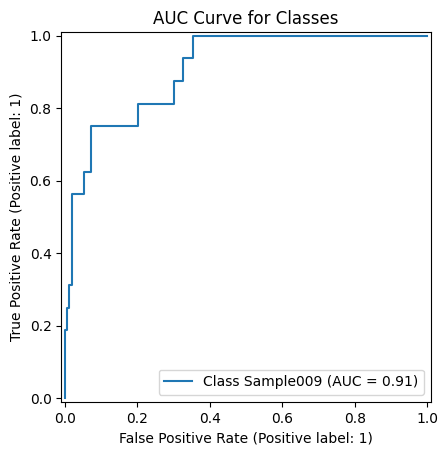

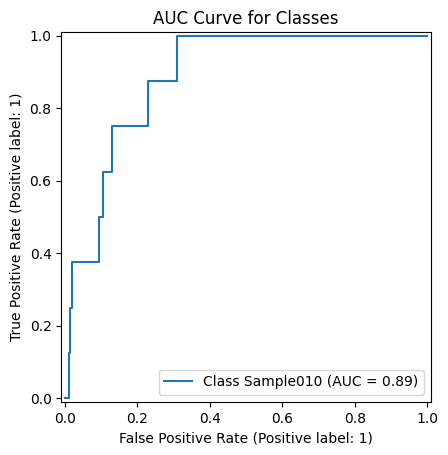

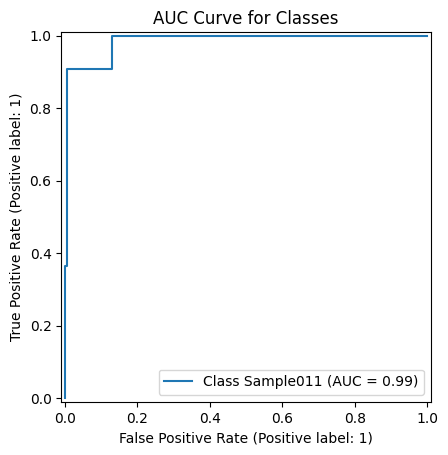

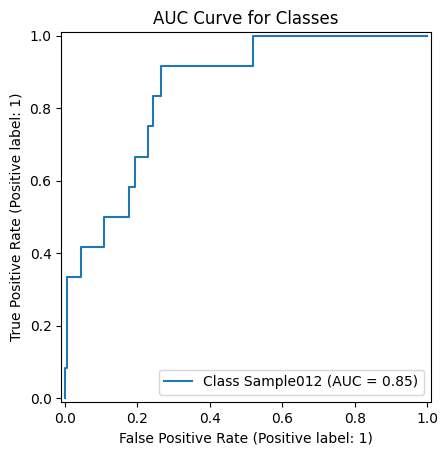

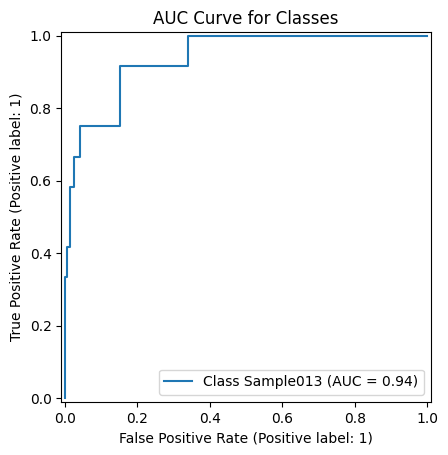

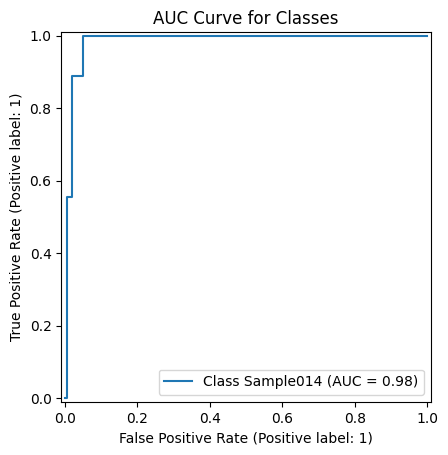

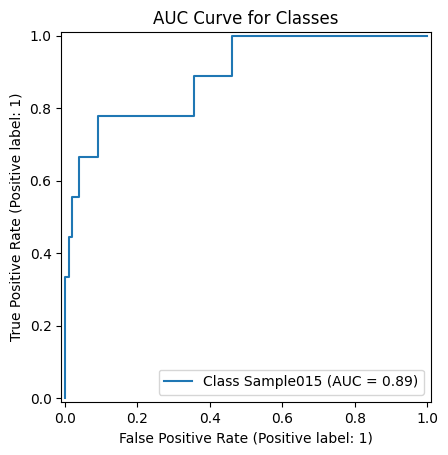

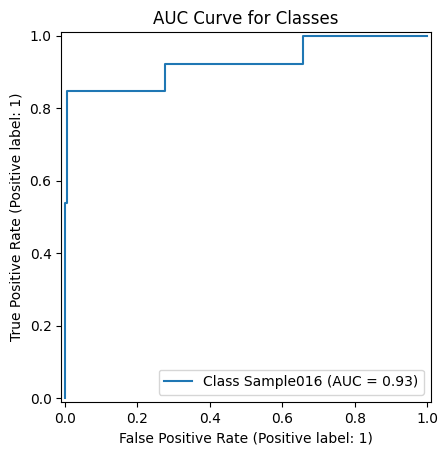

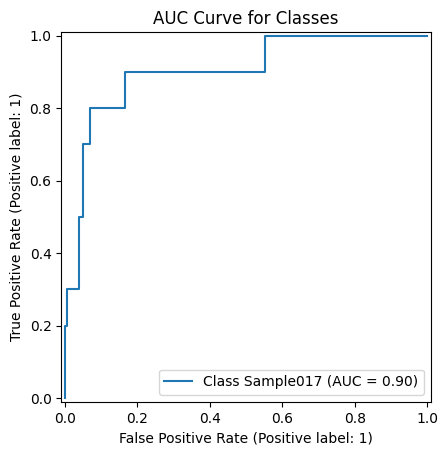

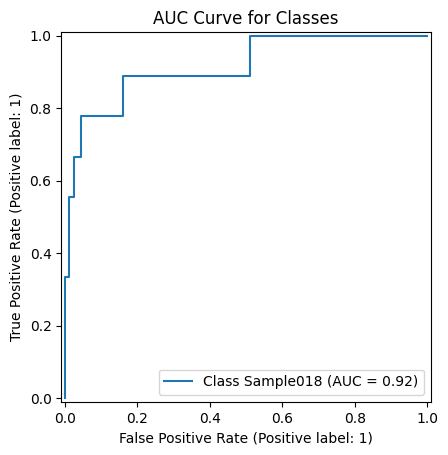

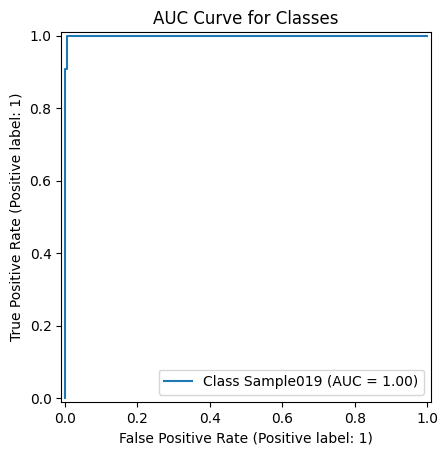

In [27]:
# AUC Calculation and Curve
print("Calculating AUC...")
y_pred_proba = best_classifier.predict_proba(X_test)
auc_value = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
print(f"AUC Value: {auc_value:.2f}")

# Plot AUC curve for each class
for i, class_name in enumerate(valid_classes):
    RocCurveDisplay.from_predictions(y_test == i, y_pred_proba[:, i], name=f"Class {class_name}")
    plt.title("AUC Curve for Classes")
    plt.show()


In [25]:
# Comparative Table for Model Metrics
image_metrics = {
    "Metric": ["Accuracy", "AUC"],
    "Value": [accuracy * 100, auc_value]
}
image_table = DataFrame(image_metrics)
print(image_table)


     Metric      Value
0  Accuracy  60.287081
1       AUC   0.920225
